In [1]:
import os
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import json

from utils.dlt import *
from utils.files import FileName
from utils.skeleton_keypoints import *
from utils.motion_visualize_tool import *

In [2]:
with open("cube/subsets_forceplate.json", "r") as f:
    subsets = json.load(f)

imgpoints = []
for i in [1, 2, 3, 4]:
    imgpoints.append(subsets[f"{i}.mp4"])
imgpoints = np.array(imgpoints, dtype=np.float32)

In [3]:
with open("cube/3d_points_forceplate.json", "r") as f:
    points = json.load(f)
cube_3d = np.array(points["object_point"], dtype=np.float32)
objpoints = np.array([cube_3d for _ in range(len(imgpoints))] , dtype=np.float32)

In [4]:
print(f"imgpoints: {imgpoints.shape}")
print(f"objpoints: {objpoints.shape}")

imgpoints: (4, 6, 2)
objpoints: (4, 6, 3)


In [5]:
cam = 4

p1 = prepare_matrix(imgpoints[0], objpoints[0])
p2 = prepare_matrix(imgpoints[1], objpoints[1])
p3 = prepare_matrix(imgpoints[2], objpoints[2])
p4 = prepare_matrix(imgpoints[3], objpoints[3])
P = np.array([p1, p2, p3, p4], dtype=np.float32)

cube_array = pose_recon_2c(cam, P, imgpoints)

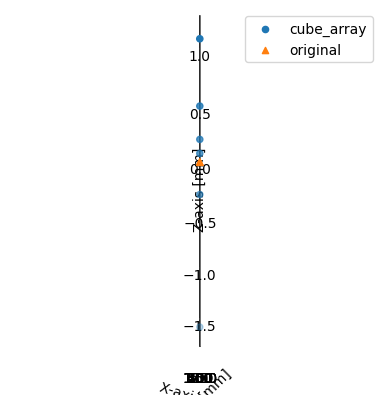

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_array[:, 0], cube_array[:, 1], cube_array[:, 2], marker='o', label='cube_array')
ax.scatter(cube_3d[:, 0], cube_3d[:, 1], cube_3d[:, 2], marker='^', label='original')
ax.set_xlabel('X-axis [mm]')
ax.set_ylabel('Y-axis [mm]')
ax.set_zlabel('Z-axis [mm]')
ax.legend()
ax.set_aspect('equal')
plt.show()

In [7]:
data_num = 0

camera_name1 = "1"
camera_name2 = "2"
camera_name3 = "3"
camera_name4 = "4"

cam1_dir = f"data/hirasaki_{camera_name1}_{data_num}/"
cam2_dir = f"data/hirasaki_{camera_name2}_{data_num}/"
cam3_dir = f"data/hirasaki_{camera_name3}_{data_num}/"
cam4_dir = f"data/hirasaki_{camera_name4}_{data_num}/"

cam1_position = pd.read_csv(os.path.join(cam1_dir, FileName.position_data), index_col="frame")
cam2_position = pd.read_csv(os.path.join(cam2_dir, FileName.position_data), index_col="frame")
cam3_position = pd.read_csv(os.path.join(cam3_dir, FileName.position_data), index_col="frame")
cam4_position = pd.read_csv(os.path.join(cam4_dir, FileName.position_data), index_col="frame")

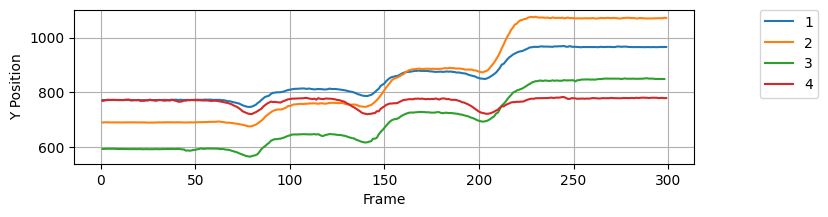

In [8]:
name = "LEFT_ANKLE"

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(cam1_position.index, cam1_position[f"{name}_y"], label=camera_name1)
ax.plot(cam2_position.index, cam2_position[f"{name}_y"], label=camera_name2)
ax.plot(cam3_position.index, cam3_position[f"{name}_y"], label=camera_name3)
ax.plot(cam4_position.index, cam4_position[f"{name}_y"], label=camera_name4)
ax.grid()
ax.set_xlabel('Frame')
ax.set_ylabel('Y Position')
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)
plt.show()

In [9]:
df_camera_sync = pd.read_csv("camera_sync.csv")

toe_off_1 = df_camera_sync["toe_off_1"].iloc[data_num]
toe_off_2 = df_camera_sync["toe_off_2"].iloc[data_num]
toe_off_3 = df_camera_sync["toe_off_3"].iloc[data_num]
toe_off_4 = df_camera_sync["toe_off_4"].iloc[data_num]

delay_1 = toe_off_1 - toe_off_1
delay_2 = toe_off_2 - toe_off_1
delay_3 = toe_off_3 - toe_off_1
delay_4 = toe_off_4 - toe_off_1

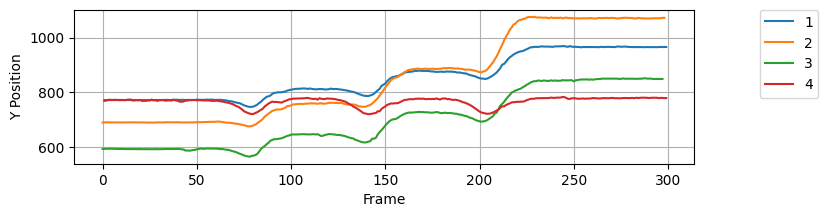

In [10]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(cam1_position.index - delay_1, cam1_position[f"{name}_y"], label=camera_name1)
ax.plot(cam2_position.index - delay_2, cam2_position[f"{name}_y"], label=camera_name2)
ax.plot(cam3_position.index - delay_3, cam3_position[f"{name}_y"], label=camera_name3)
ax.plot(cam4_position.index - delay_4, cam4_position[f"{name}_y"], label=camera_name4)
ax.grid()
ax.set_xlabel('Frame')
ax.set_ylabel('Y Position')
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)
plt.show()

In [11]:
cam1_position["ID"] = cam1_position.index - delay_1
cam2_position["ID"] = cam2_position.index - delay_2
cam3_position["ID"] = cam3_position.index - delay_3
cam4_position["ID"] = cam4_position.index - delay_4

In [12]:
cam1_position = cam1_position.loc[cam1_position["ID"] > 0]
cam2_position = cam2_position.loc[cam2_position["ID"] > 0]
cam3_position = cam3_position.loc[cam3_position["ID"] > 0]
cam4_position = cam4_position.loc[cam4_position["ID"] > 0]

In [13]:
cam1_position.set_index("ID", inplace=True, drop=True)
cam2_position.set_index("ID", inplace=True, drop=True)
cam3_position.set_index("ID", inplace=True, drop=True)
cam4_position.set_index("ID", inplace=True, drop=True)

In [14]:
min_frame = max(cam1_position.index.min(), cam2_position.index.min(), cam3_position.index.min())
max_frame = min(cam1_position.index.max(), cam2_position.index.max(), cam3_position.index.max())

print(min_frame, max_frame)

1.0 297.0


In [15]:
frame = min_frame
cam1_pose = cam1_position.loc[frame].values.reshape(-1, 2)
cam2_pose = cam2_position.loc[frame].values.reshape(-1, 2)
cam3_pose = cam3_position.loc[frame].values.reshape(-1, 2)
cam4_pose = cam4_position.loc[frame].values.reshape(-1, 2)
pose = np.array([cam1_pose, cam2_pose, cam3_pose, cam4_pose], dtype=np.float32)
pose_result = pose_recon_2c(cam, P, pose)

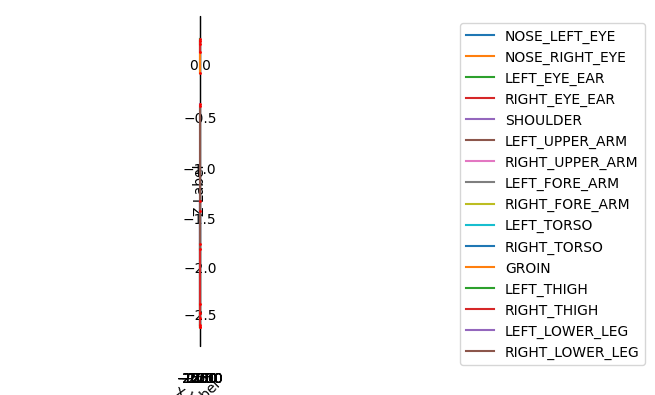

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for key, value in exp_keypoints_connections.items():
    start_idx = value[0]
    end_idx = value[1]
    ax.plot([pose_result[start_idx][0], pose_result[end_idx][0]],
            [pose_result[start_idx][1], pose_result[end_idx][1]],
            [pose_result[start_idx][2], pose_result[end_idx][2]], label=key)
for i in range(len(pose_result)):
    ax.scatter(pose_result[i][0], pose_result[i][1], pose_result[i][2], color='r', s=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
ax.set_aspect('equal')
plt.show()

In [17]:
columns = [f"{kpt}_{xyz}" for kpt in exp_keypoints_list for xyz in ["x", "y", "z"]]
position_df = pd.DataFrame(columns=columns)
position_df.index.name = 'frame'

for frame in range(int(min_frame), int(max_frame) + 1):
    cam1_pose = cam1_position.loc[frame].values.reshape(-1, 2)
    cam2_pose = cam2_position.loc[frame].values.reshape(-1, 2)
    cam3_pose = cam3_position.loc[frame].values.reshape(-1, 2)
    cam4_pose = cam4_position.loc[frame].values.reshape(-1, 2)
    pose = np.array([cam1_pose, cam2_pose, cam3_pose, cam4_pose], dtype=np.float32)
    pose_result = pose_recon_2c(cam, P, pose)
    position_df.loc[frame] = pose_result.ravel()

position_df

NOSE_x       NOSE_y        NOSE_z   LEFT_EYE_x  LEFT_EYE_y  \
frame                                                                    
1      -655.890991  1063.210532 -1.354111e+09  -502.370669  966.131423   
2      -644.259087  1057.793458 -1.155809e+09  -491.119218  960.907058   
3      -640.709587  1056.754127 -1.120736e+09  -500.922683  968.853082   
4      -646.952664  1065.001622 -1.237020e+09  -499.503485  968.018779   
5      -646.912084  1064.330254 -1.220493e+09  -490.538299  962.508543   
...            ...          ...           ...          ...         ...   
293    3846.621061   863.256023  6.070687e+09  3873.756253  725.854660   
294    3847.358025   858.423197  6.142265e+09  3876.155236  721.548770   
295    3851.444055   855.441855  6.213831e+09  3882.014001  713.267137   
296    3847.986116   856.369097  6.158940e+09  3879.904949  716.178749   
297    3848.626507   858.493192  6.134768e+09  3879.541631  716.842119   

         LEFT_EYE_z  RIGHT_EYE_x  RIGHT_EYE_y   RIGHT_EYE_z   LEFT_EAR_x  ...  \
frame                                                                     ...   
1      1.779180e+09  -525.947040   914.553653  1.537283e+09  -550.930395  ...   
2      1.970832e+09  -518.351453   909.323111  1.682385e+09  -557.290520  ...   
3      1.787019e+09  -519.022329   913.307635  1.649234e+09  -570.539775  ...   
4      1.806368e+09  -517.794684   913.176998  1.678109e+09  -584.423696  ...   
5      1.955082e+09  -517.577301   912.366229  1.697868e+09  -562.194478  ...   
...             ...          ...          ...           ...          ...  ...   
293    8.929655e+09  3872.784027   873.155316  6.074717e+09  3583.794598  ...   
294    9.018523e+09  3874.848368   871.767133  6.093979e+09  3587.435660  ...   
295    9.200065e+09  3879.373832   867.759336  6.221610e+09  3588.679750  ...   
296    9.106481e+09  3877.228867   870.037790  6.133500e+09  3586.921899  ...   
297    9.108127e+09  3878.870667   868.626086  6.169799e+09  3589.928114  ...   

        LEFT_KNEE_z  RIGHT_KNEE_x  RIGHT_KNEE_y  RIGHT_KNEE_z  LEFT_ANKLE_x  \
frame                                                                         
1     -1.823674e+10  -1668.594991   1718.103946 -1.870766e+10   -934.564004   
2     -1.808187e+10  -1662.128548   1711.082301 -1.854464e+10   -932.367878   
3     -1.802215e+10  -1660.701791   1706.036364 -1.847939e+10   -926.191555   
4     -1.803987e+10  -1665.130317   1707.608621 -1.853241e+10   -927.924681   
5     -1.811265e+10  -1661.093106   1709.162525 -1.852725e+10   -928.896934   
...             ...           ...           ...           ...           ...   
293   -8.665101e+09   3275.311536   1383.170164 -8.776316e+09   3416.405368   
294   -8.613792e+09   3274.052523   1386.397653 -8.808565e+09   3416.455433   
295   -8.667936e+09   3277.024563   1384.526357 -8.761697e+09   3415.964256   
296   -8.574765e+09   3276.966702   1383.456221 -8.756434e+09   3416.216688   
297   -8.555685e+09   3276.994639   1382.256750 -8.725970e+09   3415.637549   

       LEFT_ANKLE_y  LEFT_ANKLE_z  RIGHT_ANKLE_x  RIGHT_ANKLE_y  RIGHT_ANKLE_z  
frame                                                                           
1       1307.646235 -4.328955e+09    -951.331589    1155.678498  -4.514897e+09  
2       1303.981782 -4.262374e+09    -943.727970    1150.192118  -4.373867e+09  
3       1298.234836 -4.137471e+09    -945.057179    1148.505834  -4.352402e+09  
4       1297.471419 -4.137451e+09    -941.024841    1145.641788  -4.287809e+09  
5       1300.384491 -4.181978e+09    -940.852542    1147.733304  -4.309034e+09  
...             ...           ...            ...            ...            ...  
293     1217.740842 -4.812031e+08    3414.992512    1044.756909  -1.076736e+09  
294     1217.911905 -4.875246e+08    3415.452062    1046.719908  -1.092830e+09  
295     1220.527909 -5.241638e+08    3415.982046    1046.694850  -1.094917e+09  
296     1219.072126 -5.088921e+08    3415.477295    1047.208504  -1.116184e+

In [19]:
plot_3d_motion_exp(position_df/1000, graph_show=True)